<a href="https://colab.research.google.com/github/iuricimatec/depthmap/blob/main/epipolar_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How do I extract depth from an image?
How do we estimate depth? Our eyes estimate depth by comparing the image obtained by our left and right eye. The minor displacement between both viewpoints is enough to calculate an approximate depth map. We call the pair of images obtained by our eyes a stereo pair.

if so, I must use 2 cameras to simulate such scenario. 
What's the left camera? and what's the right one?


References
https://docs.opencv.org/3.4/dd/d53/tutorial_py_depthmap.html

https://ez.analog.com/depth-perception-ranging-technologies/lidar-solutions/3d-tof-depth-sensing/f/q-a/561113/how-to-get-a-valid-depth-map-in-python

https://github.com/analogdevicesinc/aditof_sdk/blob/master/bindings/python/examples/first_frame/first_frame.py

https://li-chongyi.github.io/proj_SR.html


https://answers.opencv.org/question/185947/how-to-resolve-a-sadwindowsize-error/


https://medium.com/yodayoda/from-depth-map-to-point-cloud-7473721d3f

In [ ]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt


from PIL import Image

# to mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
pd.set_option('display.max_columns', None)

Mounted at /content/gdrive


In [ ]:
# import dataset
df = pd.read_csv(
      '/content/gdrive/MyDrive/MCTI/Bolsa/dataset_skeleton.csv', index_col=0
)

In [ ]:
df.count()

mark1_c1_y    3762
mark2_c1_x    3760
mark2_c1_y    3760
mark3_c1_x    3735
mark3_c1_y    3735
mark4_c1_x    3452
mark4_c1_y    3452
mark1_c2_x    3762
mark1_c2_y    3762
mark2_c2_x    3760
mark2_c2_y    3760
mark3_c2_x    3757
mark3_c2_y    3757
mark4_c2_x    3701
mark4_c2_y    3701
mark1_c3_x    3762
mark1_c3_y    3762
mark2_c3_x    3749
mark2_c3_y    3749
mark3_c3_x    3704
mark3_c3_y    3704
mark4_c3_x    3459
mark4_c3_y    3459
dtype: int64

In [ ]:
# input CSV from Douglas. His code output is a CSV with tuple (x,y) for all markers. 
# how will I construct such a similar out put to match (x,y) from images and assign Z's? 
df

,mark1_c1_y,mark2_c1_x,mark2_c1_y,mark3_c1_x,mark3_c1_y,mark4_c1_x,mark4_c1_y,mark1_c2_x,mark1_c2_y,mark2_c2_x,mark2_c2_y,mark3_c2_x,mark3_c2_y,mark4_c2_x,mark4_c2_y,mark1_c3_x,mark1_c3_y,mark2_c3_x,mark2_c3_y,mark3_c3_x,mark3_c3_y,mark4_c3_x,mark4_c3_y
mark1_c1_x,,,,,,,,,,,,,,,,,,,,,,,
232,47,237.0,201.0,240.0,351.0,233.0,497.0,281,92,291.0,236.0,296.0,387.0,203.0,509.0,265,123,274.0,256.0,282.0,397.0,292.0,527.0
232,47,237.0,200.0,240.0,351.0,233.0,497.0,281,92,291.0,236.0,296.0,387.0,204.0,509.0,265,123,273.0,256.0,282.0,397.0,291.0,527.0
232,47,237.0,201.0,240.0,351.0,234.0,497.0,281,92,291.0,236.0,296.0,388.0,204.0,509.0,265,123,273.0,256.0,282.0,397.0,292.0,527.0
232,46,235.0,198.0,238.0,347.0,231.0,501.0,281,91,289.0,234.0,290.0,388.0,198.0,511.0,266,122,278.0,255.0,291.0,396.0,303.0,527.0
233,48,235.0,202.0,236.0,352.0,229.0,496.0,281,93,289.0,237.0,291.0,389.0,306.0,527.0,264,123,274.0,255.0,283.0,396.0,293.0,529.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,27,229.0,150.0,226.0,296.0,190.0,407.0,280,61,273.0,184.0,249.0,276.0,251.0,283.0,268,98,282.0,180.0,315.0,307.0,377.0,400.0
240,17,273.0,121.0,329.0,271.0,290.0,392.0,278,94,265.0,236.0,249.0,296.0,251.0,304.0,259,87,249.0,154.0,206.0,290.0,215.0,454.0
286,98,372.0,234.0,357.0,356.0,NaN,NaN,277,95,262.0,238.0,251.0,312.0,275.0,368.0,261,87,251.0,154.0,201.0,301.0,182.0,487.0


In [ ]:
# Comparing an image and its neighboor of the same camera.
# Left image paths
pathL = '/content/gdrive/MyDrive/MCTI/dataset/camera1/new/'
# Right image paths
pathR = '/content/gdrive/MyDrive/MCTI/dataset/camera2/new/'
print(os.listdir(pathL))
print(os.listdir(pathR))
# Potential fix 
# os.environ['OPENCV_IO_MAX_IMAGE_PIXELS']=str(2**64)

filenameL = pathL + '0032.png'
filenameR = pathR + '0032.png'

['0085.png', '1288.png', '2636.png', '3312.png', '0052.png', '1505.png', '2965.png', '2018.png', '0046.png', '1539.png', '2554.png', '2024.png', '1713.png', '1908.png', '1707.png', '1934.png', '2742.png', '0250.png', '2568.png', '2030.png', '2756.png', '1061.png', '2597.png', '3110.png', '1075.png', '3448.png', '0278.png', '0287.png', '2583.png', '3104.png', '0244.png', '1920.png', '0293.png', '2540.png', '3105.png', '2233.png', '1048.png', '1935.png', '0279.png', '0292.png', '1060.png', '2582.png', '1712.png', '1074.png', '3139.png', '2541.png', '2596.png', '3111.png', '3138.png', '2569.png', '2555.png', '1706.png', '1049.png', '2226.png', '2232.png', '2227.png', '0286.png', '2743.png', '2019.png', '2031.png', '1921.png', '0090.png', '3313.png', '1909.png', '1289.png', '3475.png', '3461.png', '1510.png', '3449.png', '0084.png', '1276.png', '3307.png', '1262.png', '1538.png', '0251.png', '0245.png', '2780.png', '2757.png', '1504.png', '2025.png', '2958.png', '2794.png', '1470.png', '29

In [ ]:
##
# https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html
##
img1 = cv.imread(filenameL, cv.IMREAD_GRAYSCALE)  #queryimage # left image
img2 = cv.imread(filenameR, cv.IMREAD_GRAYSCALE) #trainimage # right image
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [ ]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [ ]:
def drawlines(img1,img2,lines,pts1,pts2):
  # img1 - image on which we draw the epilines for the points in img2 lines - corresponding epilines ''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


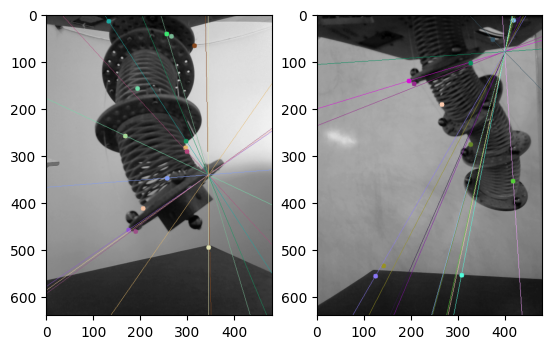

In [ ]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()